In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, bernoulli, norm
from market_simulation import * 
import os
import numpy as np
import xarray as xr
import json
from scipy.special import expit
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns

def sample_market_belief(s, SMN):
    """
    Samples market belief for a prototype and sets feedback boundaries.
    """
    SMN['alpha_b'][s] = np.random.normal(0, 1)  # Sample from a Normal distribution
    SMN['y_min'][s], SMN['y_max'][s] = -2, 2    # Set fixed feedback boundaries
    return SMN


def sample_prototype_belief(s, m, N, c_e, SMN):
    """
    Uses cost to simulate prototype outcome based on market belief.
    """
    # Convert alpha_b to probability and simulate prototype outcome
    SMN['x_b'][s, m] = np.random.binomial(N, expit(SMN['alpha_b'][s]))
    # Adjust cash based on the cost of experiment
    SMN['cash'][s, m] = SMN['cash'][s, m-1] - c_e if m > 0 else SMN['cash'][s, 0] - c_e
    return SMN


def experiment_get_y_from_real_market(s, m, N, SMN):
    """
    Samples new real market beliefs and calculates feedback by combining 
    prototype belief outcome and real market outcome.
    """
    # Sample alpha_r^s from a Normal distribution and simulate real market outcome
    SMN['alpha_r'][s] = np.random.normal(-1, 1)
    SMN['x_r'][s, m] = np.random.binomial(N, expit(SMN['alpha_r'][s]))
    
    # Calculate the feedback y_r^s,m as the sum of belief and real market outcomes
    SMN['y_r'][s, m] = SMN['x_b'][s, m] + SMN['x_r'][s, m]
    return SMN


def determine_next_action(s, m, b, SMN):
    y_r_s_m = SMN['y_r'][s, m].item()
    c_s_m = SMN['cash'][s, m].item()
    c_s_0 = SMN['cash'][s, 0].item()
    y_min_s = SMN['y_min'][s].item()
    y_max_s = SMN['y_max'][s].item()

    print(f"Prototype {s}, Experiment {m}: y_r_s_m={y_r_s_m}, c_s_m={c_s_m}, c_s_0={c_s_0}, y_min_s={y_min_s}, y_max_s={y_max_s}")

    if y_r_s_m > y_max_s:
        return "scale"
    elif c_s_m < b * c_s_0:
        return "pivot"
    elif y_min_s <= y_r_s_m <= y_max_s:
        return "re-nail"
    elif y_r_s_m < y_min_s:
        return "pivot"
    elif c_s_m == 0:
        return "fail"
    else:
        return "unknown"


def update_prior(s, m, N, SMN, model_file, data_dir='stan_data', fit_dir='stan_fits'):
    """
    Updates prior beliefs and saves the Stan fit object for later use.

    Parameters:
    - s (int): Index of the current prototype.
    - m (int): Index for the current market experiment.
    - SMN (xarray.Dataset): Dataset containing the market and production data.
    - model_file (str): Path to the Stan model file.
    - data_dir (str): Directory to store data files.
    - fit_dir (str): Directory to store fit files.

    Returns:
    - Updates the SMN dataset with new inferred values for alpha_b.
    - Saves the Stan fit object to a file.
    """
    # Prepare data for Stan model
    data = {
        'E': 1,  # Assuming one segment for simplicity
        'N': N,  # Number of trials, assuming 1 for binary outcome
        'S': [int(SMN['y_r'][s, m].item())],  # Successes, feedback from real market
        'segment': [1]  # Segment index
    }

    # Define file paths for data and fit
    data_file = os.path.join(data_dir, f'data_s{s}_m{m}.json')
    fit_file = os.path.join(fit_dir, f'fit_s{s}_m{m}.csv')

    # Save data to a JSON file
    os.makedirs(data_dir, exist_ok=True)
    with open(data_file, 'w') as f:
        json.dump(data, f)

    # Compile and fit the Stan model
    print("Fitting the Stan model...")
    model = CmdStanModel(stan_file=model_file)
    fit = model.sample(data=data)

    # Save the fit object
    os.makedirs(fit_dir, exist_ok=True)
    fit.save_csvfiles(dir=fit_dir)

    # Update SMN with the inferred values
    SMN['alpha_b'][s] = fit.stan_variable('a_bar').mean()

    return SMN

def load_fit(s, m, fit_dir='stan_fits'):
    """
    Loads a Stan fit object from file.

    Parameters:
    - s (int): Index of the prototype.
    - m (int): Index of the market experiment.
    - fit_dir (str): Directory where fit files are stored.

    Returns:
    - The loaded Stan fit object.
    """
    fit_file = os.path.join(fit_dir, f'fit_s{s}_m{m}')
    fit = CmdStanModel.sample(data=None, chains=0)
    fit = fit.from_csv(path=fit_file)
    
    return fit


def plot_alpha_shift(SMN, s, fit):
    """
    Plot the shift in alpha_b for prototype s before and after the update.

    Parameters:
    - SMN (xarray.Dataset): Dataset containing alpha_b.
    - s (int): Index of the current prototype.
    - fit: Fitted Stan model object.
    """

    # Get the posterior distribution of a_bar
    a_bar_posterior = fit.stan_variable('a_bar')

    plt.figure(figsize=(10, 6))
    plt.hist(a_bar_posterior, bins=30, alpha=0.5, label='Posterior of $\\alpha_b^s$')
    plt.axvline(x=SMN['alpha_b'][s], color='r', linestyle='dashed', linewidth=2, label='Updated $\\alpha_b^s$')
    plt.axvline(x=0, color='g', linestyle='dashed', linewidth=2, label='Initial $\\alpha_b^s$')
    plt.title('Shift in $\\alpha_b^s$')
    plt.xlabel('$\\alpha_b^s$')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

S, M, N = 10, 10, 1  # Example sizes for illustration
b = .1
cost_per_experiment = 1

SMN = xr.Dataset(
    {
        'alpha_b': ('S', np.zeros(S)),  # Market belief parameter for each prototype
        'alpha_r': ('S', np.zeros(S)),  # Market belief parameter for each prototype

        'y_r': (('S', 'M'), np.zeros((S, M))),  # Real market feedback
        'cash': (('S', 'M'), np.zeros((S, M))),  # Capital for each prototype and market experiment
        'y_min': ('S', np.full(S, -2)),  # Minimum feedback threshold
        'y_max': ('S', np.full(S, 2)),  # Maximum feedback threshold
        'x_b': (('S', 'M'), np.zeros((S, M))),  # Belief market outcome
        'x_r': (('S', 'M'), np.zeros((S, M))),  # Real market outcome
    },
    coords={
        'S': np.arange(S),
        'M': np.arange(M)
    }
)

SMN['cash'][0,0] = 10  # Initial capital 

def experiment_process(SMN, s, m, N, cost_per_experiment):
    SMN = sample_prototype_belief(s, m, N, cost_per_experiment, SMN)
    SMN = experiment_get_y_from_real_market(s, m, N,SMN)
    
    action = determine_next_action(s, m, b, SMN)

    if action == "re-nail":
        SMN = update_prior(s, m, N, SMN, model_file="stan/idea_exp.stan")
        plot_alpha_shift(SMN, s, fit)
        return "re-nail"  # Indicate that we should re-nail and thus repeat the prototype belief sampling
    elif action == "pivot":
        SMN = update_prior(s, m, N, SMN, model_file="stan/idea_exp.stan")
        plot_alpha_shift(SMN, s, fit)
        return "pivot"  # Indicate that market belief needs re-sampling
    # Handle "scale" and "fail" as needed

    return None  # No specific action required

def start_experiment(SMN, cost_per_experiment):
    for s in range(S):
        print("current market is", s)
        
        while True:
            SMN = sample_market_belief(s, SMN)
            
            for m in range(M):
                print("current market is", m, "given", s, "market")
                action = experiment_process(SMN, s, m, N, cost_per_experiment)
                
                if action == "re-nail":
                    break  # Break the inner loop, will cause the outer while loop to reiterate
                elif action == "pivot":
                    break  # Break the inner loop and also causes re-sampling of market belief
                
                if m == M-1:  # End of market experiments for this prototype
                    break
            
            if action != "pivot":  # Break the while loop unless we need to pivot
                break
        print(action)

start_experiment(SMN, cost_per_experiment)


current market is 0
current market is 0 given 0 market
Prototype 0, Experiment 0: y_r_s_m=2.0, c_s_m=9.0, c_s_0=9.0, y_min_s=-2, y_max_s=2
Fitting the Stan model...


16:23:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:23:51 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
16:23:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
16:23:51 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted
16:23:51 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted


16:23:51 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=N; dims declared=(1); dims found=() (in '/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpsqafxmz7/tmpxqbmi6hl.stan', line 4, column 4 to column 22)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=N; dims declared=(1); dims found=() (in '/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpsqafxmz7/tmpxqbmi6hl.stan', line 4, column 4 to column 22)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=N; dims declared=(1); dims found=() (in '/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpsqafxmz7/tmpxqbmi6hl.stan', line 4, column 4 to column 22)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=N; dims declared=(1); dims found=() (in '/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpsqafxmz7/tmpxqbmi6hl.stan', line 4, column 4 to column 22)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/hyunjimoon/Dropbox (MIT)/Ops Entreps cases xx/Ops4Entrep-backend/simulation/stan/idea_exp', 'id=1', 'random', 'seed=5449', 'data', 'file=/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpz9mh7yzl/bkempe32.json', 'output', 'file=/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpz9mh7yzl/idea_expuk3d9q38/idea_exp-20240330162351_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpz9mh7yzl/idea_expuk3d9q38/idea_exp-20240330162351_1.csv
 console_msgs (if any):
	/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/tmpz9mh7yzl/idea_expuk3d9q38/idea_exp-20240330162351_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!

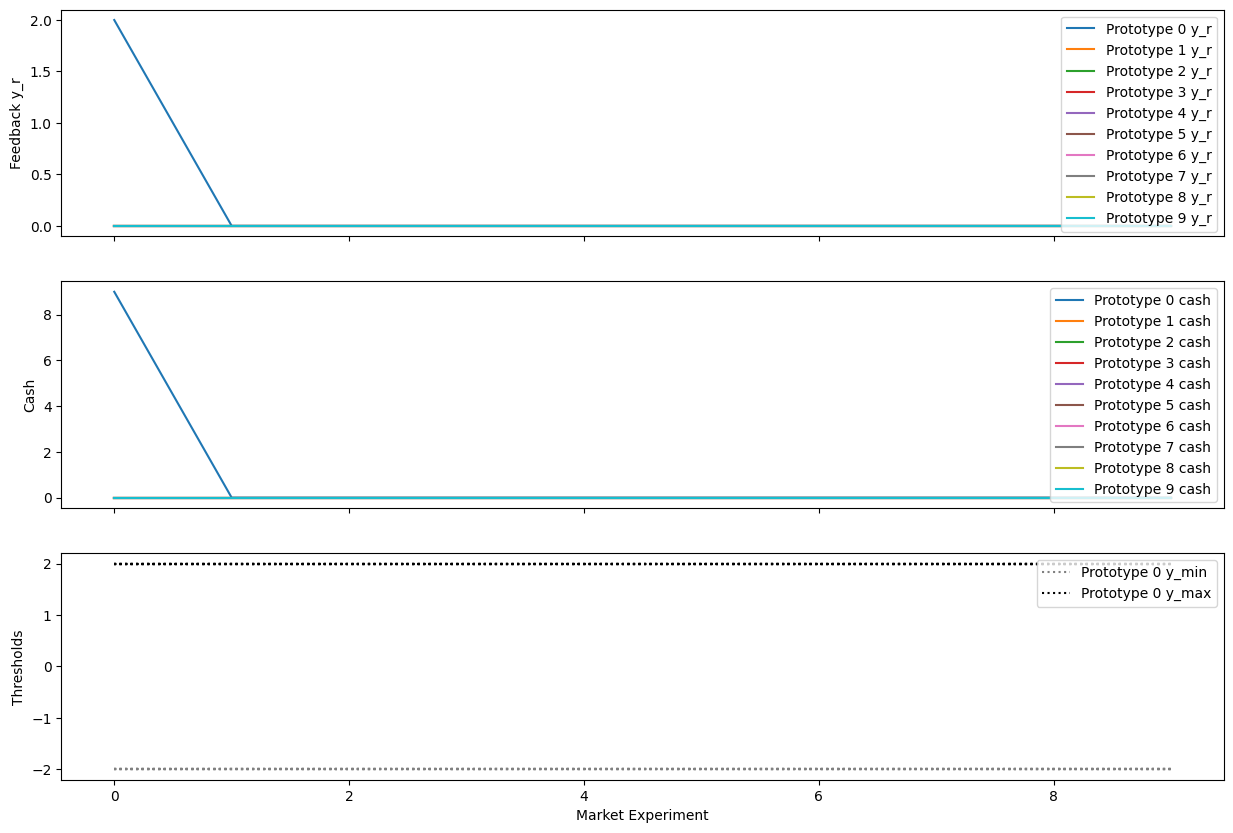

In [10]:
def plot_hyperparameters(SMN, S, M):
    fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    for s in range(S):
        y_r_s_m = SMN['y_r'][s, :].values
        c_s_m = SMN['cash'][s, :].values
        y_min_s = SMN['y_min'][s].values
        y_max_s = SMN['y_max'][s].values

        ax[0].plot(range(M), y_r_s_m, label=f'Prototype {s} y_r')
        ax[1].plot(range(M), c_s_m, label=f'Prototype {s} cash')
        ax[2].hlines(y_min_s, 0, M-1, colors='gray', linestyles='dotted', label=f'Prototype {s} y_min' if s == 0 else "")
        ax[2].hlines(y_max_s, 0, M-1, colors='black', linestyles='dotted', label=f'Prototype {s} y_max' if s == 0 else "")

    ax[0].set_ylabel('Feedback y_r')
    ax[0].legend()
    ax[1].set_ylabel('Cash')
    ax[1].legend()
    ax[2].set_ylabel('Thresholds')
    ax[2].legend()

    plt.xlabel('Market Experiment')
    plt.show()

plot_hyperparameters(SMN, S, M)